# NYJ Receiver-by-Bucket Efficiency (Context-Adjusted)

This notebook analyzes the New York Jets passing game by estimating which receiver target types are most efficient after controlling for basic game situation and target difficulty.

## What this notebook does
- Loads league-wide play-by-play targets for the selected season and filters to NYJ targets
- Builds a league-trained expected EPA baseline using game context and target descriptors
- Computes context-adjusted residual EPA: `epa_resid = epa - exp_epa_oof`
- Aggregates residual EPA by receiver and target bucket (depth × direction) with shrinkage and bootstrap uncertainty
- Produces:
  - A receiver-by-bucket heatmap of context-adjusted efficiency
  - A table of actionable “increase/decrease” usage recommendations per receiver
  - A counterfactual reallocation curve estimating expected EPA gain from shifting targets toward high-value receiver-bucket pairs

## Key output interpretation
- Positive residual EPA indicates NYJ performance above league expectation in that situation
- Receiver-by-bucket results are intended for usage optimization (who to target, where), not causal claims about player skill


In [1]:
!pip -q install nfl_data_py pandas pyarrow
import numpy as np
import pandas as pd
import nfl_data_py as nfl
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.3.2 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
SEASON = 2025
TEAM = "NYJ"

pbp = nfl.import_pbp_data([SEASON], downcast=True)

print("pbp rows:", len(pbp), "cols:", pbp.shape[1])
pbp.head(10)

2025 done.
Downcasting floats.
pbp rows: 48578 cols: 372


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,None,None,None,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0.0,0.0,-0.352700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0.0,0.0,-0.190052,NaN,NaN,NaN,NaN,NaN,0.511128,-51.112808
3,85.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,1.0,0.0,1.317340,0.939998,4.750889,3.0,0.666726,0.439110,0.668940,33.105968
4,115.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0.0,0.0,-1.694360,NaN,NaN,NaN,NaN,NaN,0.492038,50.796207
5,135.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0.0,0.0,-1.284150,NaN,NaN,NaN,NaN,NaN,0.716846,-71.684570
6,166.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0.0,0.0,-0.840574,NaN,NaN,NaN,NaN,NaN,0.756109,-75.610863
7,188.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0.0,0.0,0.650589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,214.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,NO,home,ARI,...,0.0,0.0,-0.194728,NaN,NaN,NaN,NaN,NaN,0.430873,-43.087284
9,243.0,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,NO,home,ARI,...,0.0,0.0,-0.788527,1.147553,5.786526,4.0,0.664423,0.453707,0.614372,38.562782


In [3]:
pbp_season = pbp[(pbp["season"] == SEASON) & (pbp["season_type"] == "REG")].copy()

targets = pbp_season[
    (pbp_season["play_type"] == "pass") &
    (pbp_season["pass_attempt"] == 1) &
    (pbp_season["receiver_player_name"].notna()) &
    (pbp_season["epa"].notna())
].copy()

req = ["down","ydstogo","yardline_100","air_yards","pass_location","pass_length","game_seconds_remaining","qtr","game_id"]
targets = targets.dropna(subset=req).copy()

if "score_differential" not in targets.columns:
    if ("posteam_score" in targets.columns) and ("defteam_score" in targets.columns):
        targets["score_differential"] = targets["posteam_score"] - targets["defteam_score"]
    else:
        targets["score_differential"] = 0.0

for c in ["shotgun","no_huddle"]:
    if c not in targets.columns:
        targets[c] = 0
targets["shotgun"] = targets["shotgun"].fillna(0).astype(int)
targets["no_huddle"] = targets["no_huddle"].fillna(0).astype(int)

targets["depth_bucket"] = pd.cut(
    targets["air_yards"],
    bins=[-999, 5, 15, 999],
    labels=["short","intermediate","deep"]
)
targets = targets[targets["depth_bucket"].notna()].copy()

targets["bucket"] = targets["depth_bucket"].astype(str) + "_" + targets["pass_location"].astype(str)

jets_targets = targets[targets["posteam"] == TEAM].copy()
len(targets), len(jets_targets)


(16609, 472)

In [4]:
def add_features(df):
    df = df.copy()
    df["red_zone"] = (df["yardline_100"] <= 20).astype(int)
    df["late_game"] = (df["game_seconds_remaining"] <= 300).astype(int)
    df["ydstogo_cap"] = np.minimum(df["ydstogo"], 20)
    df["air_yards_cap"] = df["air_yards"].clip(-5, 40)
    df["log_ydstogo"] = np.log1p(df["ydstogo_cap"])
    df["is_late_down"] = df["down"].isin([3,4]).astype(int)
    df["late_down_x_ydstogo"] = df["is_late_down"] * df["ydstogo_cap"]
    return df

targets_fe = add_features(targets)


In [6]:
import sys
!{sys.executable} -m pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 50.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 31.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [10]:

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score

num_feats = [
    "down","yardline_100","game_seconds_remaining","score_differential","qtr",
    "shotgun","no_huddle",
    "ydstogo_cap","air_yards_cap","log_ydstogo","red_zone","late_game","late_down_x_ydstogo"
]
cat_feats = ["pass_location","pass_length"]

X = targets_fe[num_feats + cat_feats].copy()
y = targets_fe["epa"].astype(float).copy()
groups = targets_fe["game_id"].astype(str).copy()

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_feats),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_feats),
    ]
)

model = Pipeline([
    ("pre", pre),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 25)))
])

gkf = GroupKFold(n_splits=5)
oof_pred = np.full(len(X), np.nan)

for tr, te in gkf.split(X, y, groups=groups):
    model.fit(X.iloc[tr], y.iloc[tr])
    oof_pred[te] = model.predict(X.iloc[te])

targets_fe["exp_epa_oof"] = oof_pred
targets_fe["epa_resid"] = targets_fe["epa"].astype(float) - targets_fe["exp_epa_oof"].astype(float)

mae = mean_absolute_error(y, targets_fe["exp_epa_oof"])
r2 = r2_score(y, targets_fe["exp_epa_oof"])
mae, r2

(1.131190593557885, 0.01968366381327047)

In [13]:
jets_t = targets_fe[targets_fe["posteam"] == TEAM].copy()

MIN_N = 8
K_SHRINK = 25
B = 500

rb = (
    jets_t
    .groupby(["receiver_player_name","bucket"])["epa_resid"]
    .agg(n="size", mean_resid="mean")
    .reset_index()
)

rb = rb[rb["n"] >= MIN_N].copy()
rb["shrunk_resid"] = rb["mean_resid"] * (rb["n"] / (rb["n"] + K_SHRINK))

rng = np.random.default_rng(7)
grouped = jets_t.groupby(["receiver_player_name","bucket"])["epa_resid"]

ci_low = []
ci_high = []

for _, row in rb.iterrows():
    key = (row["receiver_player_name"], row["bucket"])
    x = grouped.get_group(key).to_numpy()
    means = []
    for _ in range(B):
        samp = rng.choice(x, size=len(x), replace=True)
        means.append(samp.mean())
    means = np.sort(means)
    ci_low.append(means[int(0.025 * B)])
    ci_high.append(means[int(0.975 * B)])

rb["ci_low"] = ci_low
rb["ci_high"] = ci_high

rb = rb.sort_values(["shrunk_resid","n"], ascending=[False, False]).reset_index(drop=True)
rb.head(20)


,receiver_player_name,bucket,n,mean_resid,shrunk_resid,ci_low,ci_high
0,I.Davis,short_right,9,0.838675,0.222002,-0.039592,1.883514
1,M.Taylor,intermediate_left,8,0.572867,0.138877,0.267107,0.905808
2,B.Hall,short_right,21,0.301691,0.137729,-0.197743,0.981886
3,J.Metchie,intermediate_left,8,0.348545,0.084496,-0.952912,1.450124
4,M.Taylor,short_middle,13,0.154497,0.052854,-0.172063,0.545345
5,B.Hall,short_left,13,0.151865,0.051954,-0.289086,0.729020
6,J.Metchie,short_left,14,0.144476,0.051863,-0.300450,0.575043
7,G.Wilson,short_right,11,0.157947,0.048262,-0.370220,0.916405
8,A.Lazard,short_right,8,0.150733,0.036541,-0.840105,1.390463
9,M.Taylor,short_right,15,0.061518,0.023069,-0.501866,0.578006


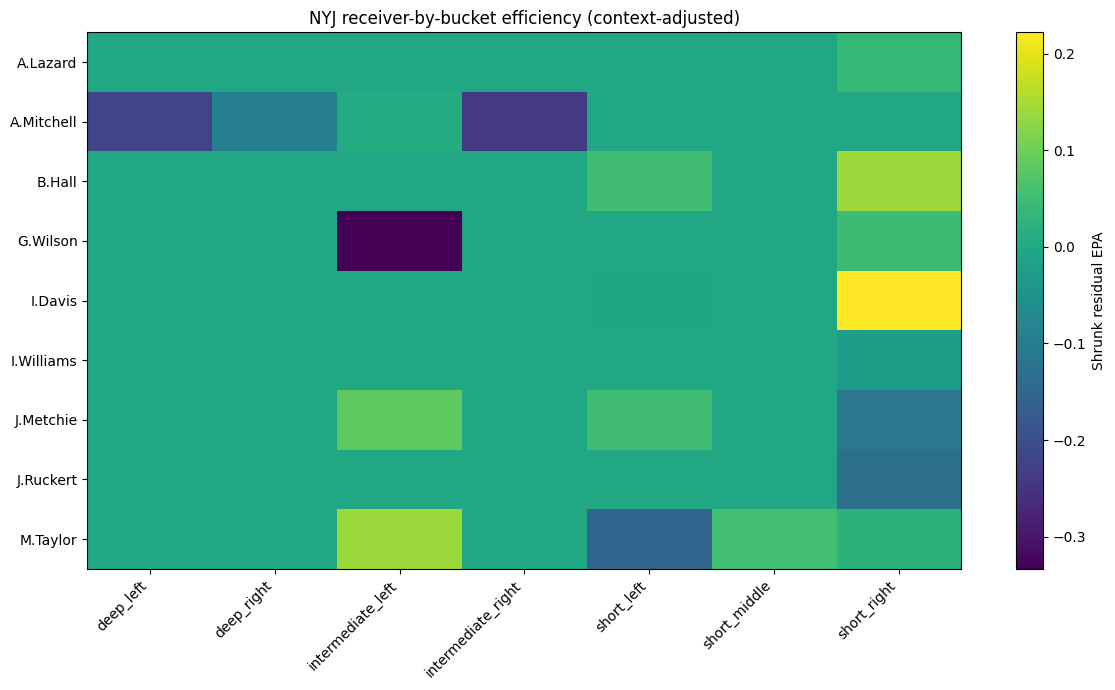

In [14]:
heat = rb.pivot(index="receiver_player_name", columns="bucket", values="shrunk_resid").fillna(0.0)

plt.figure(figsize=(12, 7))
plt.imshow(heat.values, aspect="auto")
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha="right")
plt.yticks(range(len(heat.index)), heat.index)
plt.colorbar(label="Shrunk residual EPA")
plt.title("NYJ receiver-by-bucket efficiency (context-adjusted)")
plt.tight_layout()
plt.show()


In [15]:
TOP_K_PER_RECEIVER = 2
BOT_K_PER_RECEIVER = 1

recs = []

for rec, sub in rb.groupby("receiver_player_name"):
    sub = sub.sort_values("shrunk_resid", ascending=False)
    top = sub.head(TOP_K_PER_RECEIVER)
    bot = sub.tail(BOT_K_PER_RECEIVER)

    for _, r in top.iterrows():
        recs.append([rec, "increase", r["bucket"], int(r["n"]), float(r["shrunk_resid"]), float(r["ci_low"]), float(r["ci_high"])])
    for _, r in bot.iterrows():
        recs.append([rec, "decrease", r["bucket"], int(r["n"]), float(r["shrunk_resid"]), float(r["ci_low"]), float(r["ci_high"])])

recs_df = pd.DataFrame(recs, columns=["receiver","action","bucket","n","shrunk_resid","ci_low","ci_high"])
recs_df = recs_df.sort_values(["action","shrunk_resid"], ascending=[True, False]).reset_index(drop=True)
recs_df.head(50)


,receiver,action,bucket,n,shrunk_resid,ci_low,ci_high
0,B.Hall,decrease,short_left,13,0.051954,-0.289086,0.729020
1,A.Lazard,decrease,short_right,8,0.036541,-0.840105,1.390463
2,I.Davis,decrease,short_left,9,-0.005710,-0.637670,0.706817
3,I.Williams,decrease,short_right,13,-0.022547,-0.467699,0.344112
4,J.Metchie,decrease,short_right,9,-0.113072,-0.832807,0.033447
5,J.Ruckert,decrease,short_right,12,-0.128578,-1.017597,0.049990
6,M.Taylor,decrease,short_left,13,-0.152967,-1.248694,0.251690
7,A.Mitchell,decrease,intermediate_right,11,-0.238074,-1.340748,-0.184821
8,G.Wilson,decrease,intermediate_left,14,-0.333270,-2.142951,0.028078
9,I.Davis,increase,short_right,9,0.222002,-0.039592,1.883514


In [16]:
league_bucket = (
    targets_fe
    .groupby("bucket")["epa_resid"]
    .agg(league_n="size", league_mean_resid="mean")
    .reset_index()
)

jets_bucket = (
    jets_t
    .groupby("bucket")["epa_resid"]
    .agg(jets_n="size", jets_mean_resid="mean")
    .reset_index()
)

bucket_summary = jets_bucket.merge(league_bucket, on="bucket", how="left")
bucket_summary["jets_minus_league"] = bucket_summary["jets_mean_resid"] - bucket_summary["league_mean_resid"]
bucket_summary = bucket_summary.sort_values("jets_minus_league", ascending=False).reset_index(drop=True)
bucket_summary


,bucket,jets_n,jets_mean_resid,league_n,league_mean_resid,jets_minus_league
0,short_middle,55,0.005722,1567,-0.175302,0.181024
1,short_right,126,0.104154,3680,-0.001641,0.105795
2,intermediate_right,47,0.064017,1729,0.054192,0.009825
3,intermediate_middle,21,-0.047533,1372,0.140071,-0.187604
4,intermediate_left,67,-0.146375,1700,0.045411,-0.191786
5,deep_right,28,-0.282812,1243,-0.076271,-0.206541
6,short_left,88,-0.245901,3461,-0.024399,-0.221502
7,deep_left,31,-0.483833,1263,0.005871,-0.489704
8,deep_middle,9,-0.877823,594,0.156610,-1.034433


In [17]:
rb2 = rb.copy()
rb2["pair"] = rb2["receiver_player_name"].astype(str) + " | " + rb2["bucket"].astype(str)

current_counts = jets_t.groupby(["receiver_player_name","bucket"]).size().reset_index(name="n")
current_counts["pair"] = current_counts["receiver_player_name"].astype(str) + " | " + current_counts["bucket"].astype(str)

pairs = current_counts.merge(rb2[["pair","shrunk_resid","ci_low","ci_high"]], on="pair", how="left").dropna()

pairs = pairs.sort_values("shrunk_resid", ascending=False).reset_index(drop=True)

def simulate_realloc(pairs_df, shift_per_game=4, games=None):
    if games is None:
        games = jets_t["game_id"].nunique()
    total_shift = int(shift_per_game * games)

    src = pairs_df.sort_values("shrunk_resid", ascending=True).copy()
    dst = pairs_df.sort_values("shrunk_resid", ascending=False).copy()

    src = src[src["n"] > 0].reset_index(drop=True)
    dst = dst[dst["n"] > 0].reset_index(drop=True)

    i = 0
    j = 0
    moved = 0
    gain = 0.0

    while moved < total_shift and i < len(src) and j < len(dst):
        src_pair = src.loc[i]
        dst_pair = dst.loc[j]

        if src_pair["pair"] == dst_pair["pair"]:
            j += 1
            continue

        can_move = min(src_pair["n"], total_shift - moved)
        gain += can_move * (dst_pair["shrunk_resid"] - src_pair["shrunk_resid"])
        moved += can_move

        src.loc[i, "n"] -= can_move

        if src.loc[i, "n"] <= 0:
            i += 1

    return {"games": games, "targets_shifted": moved, "total_epa_gain": gain, "epa_gain_per_game": gain / games}

simulate_realloc(pairs, shift_per_game=4)


{'games': 17,
 'targets_shifted': 68,
 'total_epa_gain': 29.19573478749431,
 'epa_gain_per_game': 1.7173961639702535}